In [1]:
%matplotlib notebook

Need the following:

    export PYTHONPATH=../python

In [6]:
import argparse
import itertools
import random
from collections import OrderedDict
import json
import time
import os

from tqdm import tqdm_notebook, tqdm

from hunt.data.nli import load_nli_data

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import pandas as pd
import h5py

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [347]:
parser = argparse.ArgumentParser()

# MLP Settings
parser.add_argument('--mlp-dim', type=int, default=1024)
parser.add_argument('--mlp-drop-rate', type=float, default=0.2)
parser.add_argument('--num-mlp-layers', type=int, default=2)
parser.add_argument('--use-bn', action='store_true')
parser.add_argument('--use-drop', action='store_true')
parser.add_argument('--use-product-feature', action='store_true')
parser.add_argument('--use-difference-feature', action='store_true')
parser.add_argument('--semantic-classifier-keep-rate', type=float, default=0.5)

# Data Settings
parser.add_argument('--data', type=str, default=os.path.expanduser('~/data/snli_1.0/snli_1.0_dev.jsonl'))
parser.add_argument('--eval-data', type=str, default=os.path.expanduser('~/data/snli_1.0/snli_1.0_dev.jsonl'))
parser.add_argument('--embeddings', type=str, default=os.path.expanduser('~/data/glove/glove.6B.300d.txt'))
parser.add_argument('--num-classes', type=int, default=3)

# Cache Settings
parser.add_argument('--cache', type=str, default=os.path.expanduser('~/cache/'))

# Preprocessing Settings
parser.add_argument('--lowercase', action='store_true')
parser.add_argument('--seq-length', type=int, default=200)

# Train Settings
parser.add_argument('--batch-size', type=int, default=512)

# Model Settings
parser.add_argument('--model-dim', type=int, default=300)
parser.add_argument('--share-params', action='store_true')

# Embedding Settings
parser.add_argument('--embedding-keep-rate', type=float, default=0.5)
parser.add_argument('--word-embedding-dim', type=int, default=300)

FLAGS = parser.parse_args({})

# Override Defaults
FLAGS.mlp_ln = True
FLAGS.use_difference_feature = True
FLAGS.use_product_feature = True
FLAGS.lowercase = True
FLAGS.use_drop = True

print(json.dumps(FLAGS.__dict__, indent=4, sort_keys=True))

{
    "batch_size": 512, 
    "cache": "/home/dexter/cache/", 
    "data": "/home/dexter/data/snli_1.0/snli_1.0_dev.jsonl", 
    "embedding_keep_rate": 0.5, 
    "embeddings": "/home/dexter/data/glove/glove.6B.300d.txt", 
    "eval_data": "/home/dexter/data/snli_1.0/snli_1.0_dev.jsonl", 
    "lowercase": true, 
    "mlp_dim": 1024, 
    "mlp_drop_rate": 0.2, 
    "mlp_ln": true, 
    "model_dim": 300, 
    "num_classes": 3, 
    "num_mlp_layers": 2, 
    "semantic_classifier_keep_rate": 0.5, 
    "seq_length": 200, 
    "share_params": false, 
    "use_bn": false, 
    "use_difference_feature": true, 
    "use_drop": true, 
    "use_product_feature": true, 
    "word_embedding_dim": 300
}


In [348]:
data_manager = load_nli_data

# Preprocess Data

In [349]:
class Timer:    
    def __init__(self, name=None, verbose=True):
        self.verbose = verbose
        self.name = name

    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        if self.verbose and self.name is not None:
            print(self.name + ' ' + str(self.interval))

## Raw Data

In [350]:
with Timer('raw_data'):
    raw_data = data_manager.load_data(FLAGS.data, FLAGS.lowercase)

Loading /home/dexter/data/snli_1.0/snli_1.0_dev.jsonl
raw_data 1.487453


In [351]:
with Timer('raw_eval_data'):
    raw_eval_data = data_manager.load_data(FLAGS.eval_data, FLAGS.lowercase)

Loading /home/dexter/data/snli_1.0/snli_1.0_dev.jsonl
raw_eval_data 0.862196


In [352]:
json.dumps(raw_data[0])

'{"example_id": "4705552913.jpg#2r1n", "hypothesis_transitions": [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], "hypothesis_tokens": ["the", "sisters", "are", "hugging", "goodbye", "while", "holding", "to", "go", "packages", "after", "just", "eating", "lunch", "."], "premise_tokens": ["two", "women", "are", "embracing", "while", "holding", "to", "go", "packages", "."], "label": "neutral", "hypothesis": "The sisters are hugging goodbye while holding to go packages after just eating lunch.", "premise": "Two women are embracing while holding to go packages.", "premise_transitions": [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]}'

## Vocab

In [353]:
# Methods

def build_vocab(datasets, keys=['premise_tokens', 'hypothesis_tokens']):
    vocabulary = set()
    for dataset in datasets:
        for k in keys:
            vocabulary.update(itertools.chain.from_iterable([example[k] for example in dataset]))
    return vocabulary

In [354]:
# Main

with Timer('Vocabulary'):
    vocabulary = build_vocab([raw_data, raw_eval_data])
    vocab_size = len(vocabulary)

print("Raw Vocab Size:", vocab_size)

Vocabulary 0.354785
('Raw Vocab Size:', 6423)


## Embeddings

In [355]:
# Methods

def read_embeddings(path, choose=lambda x: True):
    with open(path) as f:
        rows = []
        for line in f:
            parts = line.split()
            if choose(parts):
                rows.append(parts)
    return rows


def parse_embeddings(rows):
    names = [row[0] for row in rows]
    vectors = np.empty((len(rows), len(rows[0]) - 1), dtype=np.float32)
    for i, row in enumerate(rows):
        vectors[i] = map(float, row[1:])
    return vectors, names


def load_embeddings(path, vocabulary=None):
    if vocabulary is not None:
        def choose(parts):
            return parts[0] in vocabulary
    else:
        choose = lambda x: True
    
    rows = read_embeddings(FLAGS.embeddings, choose)
    vectors, names = parse_embeddings(rows)

    return vectors, names


def build_embeddings(vectors, names, vocabulary, preassigned=dict()):
    new_vocab = set(names).intersection(vocabulary).union(set(preassigned.keys()))
    idx2vocab = []
    j = 0
    
    new_vecs = np.empty((len(new_vocab), vectors.shape[1]), dtype=np.float32)
    
    for name, vec in preassigned.items():
        new_vocab.remove(name)
        idx2vocab.append(name)
        new_vecs[j] = vec
        j += 1
    
    for i, name in enumerate(names):
        if name in new_vocab:
            new_vocab.remove(name)
            idx2vocab.append(name)
            new_vecs[j] = vectors[i]
            j += 1
    
    return new_vecs, idx2vocab

In [356]:
# Main

preassigned = OrderedDict()
preassigned["_PAD"] = np.zeros(FLAGS.word_embedding_dim) # Padding
preassigned["_"] = np.zeros(FLAGS.word_embedding_dim)    # UNK (TODO: Perhaps should use pretrained value)

In [357]:
## 1. Load All Embeddings
with Timer('embeddings'):
    raw_vectors, names = load_embeddings(FLAGS.embeddings, vocabulary)

embeddings 5.548048


In [358]:
## 2. Build New Embeddings
vectors, idx2vocab = build_embeddings(raw_vectors, names, vocabulary, preassigned)

In [359]:
vocab2idx = {v: i for i, v in enumerate(idx2vocab)}

## Tokenize

In [360]:
# Methods

def tokenize(datasets, vocab2idx, keys=['premise_tokens', 'hypothesis_tokens']):
    for dataset in datasets:
        for item in dataset:
            for key in keys:
                item[key] = [vocab2idx.get(w, 1) for w in item[key]]
                
def untokenize(datasets, idx2vocab, keys=['premise_tokens', 'hypothesis_tokens']):
    for dataset in datasets:
        for item in dataset:
            for key in keys:
                item[key] = [idx2vocab[i] for i in item[key]]

In [361]:
# Main

with Timer('tokenize'):
    tokenize([raw_data, raw_eval_data], vocab2idx)

tokenize 0.368079


In [362]:
json.dumps(raw_data[0])

'{"example_id": "4705552913.jpg#2r1n", "hypothesis_transitions": [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], "hypothesis_tokens": [2, 2117, 30, 4575, 3419, 103, 896, 6, 218, 2665, 47, 112, 2061, 1962, 4], "premise_tokens": [53, 237, 30, 3918, 103, 896, 6, 218, 2665, 4], "label": "neutral", "hypothesis": "The sisters are hugging goodbye while holding to go packages after just eating lunch.", "premise": "Two women are embracing while holding to go packages.", "premise_transitions": [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]}'

## Batch Iterator

In [363]:
# Methods

class BatchIterator(object):
    def __init__(self, datasets, batch_size, loop=True):
        self.data_size = len(datasets[0])
        self.datasets = datasets
        self.index = -1
        self.batch_size = batch_size
        self.it = None
        self.loop = loop
        
        for d in datasets:
            
            assert len(d) == self.data_size
            
    def index_iterator(self):
        for i in random.sample(range(self.data_size), self.data_size):
            yield i
            
    def get_indexes(self, n):
        return [i for i in itertools.islice(self.it, n)]
    
    def reset(self):
        self.index = 0
        self.it = self.index_iterator()
        
    def __iter__(self):
        return self
    
    def next(self):
        if self.index == -1:
            self.reset()
        if self.index + self.batch_size > self.data_size:
            if self.loop:
                self.reset()
            else:
                raise StopIteration
        batch_index = np.array(self.get_indexes(self.batch_size))
        self.index += batch_index.shape[0]
        batches = []
        
        for d in self.datasets:
            b = d[batch_index]
            batches.append(b)
        return batches

In [364]:
# Main

## Flatten Datasets

datasets = dict()
datasets['p'] = np.array([x['premise_tokens'] for x in raw_data])
datasets['h'] = np.array([x['hypothesis_tokens'] for x in raw_data])
datasets['pt'] = np.array([x['premise_transitions'] for x in raw_data])
datasets['ht'] = np.array([x['hypothesis_transitions'] for x in raw_data])
datasets['label'] = np.array([data_manager.LABEL_MAP[x['label']] for x in raw_data])
datasets['eval_p'] = np.array([x['premise_tokens'] for x in raw_eval_data])
datasets['eval_h'] = np.array([x['hypothesis_tokens'] for x in raw_eval_data])
datasets['eval_pt'] = np.array([x['premise_transitions'] for x in raw_eval_data])
datasets['eval_ht'] = np.array([x['hypothesis_transitions'] for x in raw_eval_data])
datasets['eval_label'] = np.array([data_manager.LABEL_MAP[x['label']] for x in raw_eval_data])

In [365]:
d = (datasets['p'], datasets['h'], datasets['pt'], datasets['ht'], datasets['label'])
batch_it = BatchIterator(d, batch_size=FLAGS.batch_size)

In [366]:
max_step = 100

batch_it.reset()
first_step = 0
for step in range(first_step, max_step):
    batch = next(batch_it)
    
print(step)

99


# Build Model

In [369]:
class NLIModel(nn.Module):
    """
    p, h = next(batch_iterator)
    p_hat, h_hat = encode(p, h)
    o = match(p_hat, h_hat)
    logits = mlp(o)
    """
    def __init__(self, embed, encode, match, mlp):
        super(NLIModel, self).__init__()
        self.embed = embed
        self.encode = encode
        self.match = match
        self.mlp = mlp
        
    def cuda(self):
        super(NLIModel, self).cuda()
        self.embed.embed.cuda()
        
    def cpu(self):
        super(NLIModel, self).cpu()
        self.embed.embed.cpu()
        
    def forward(self, p, h):
        self.p_emb, self.h_emb = self.embed(p), self.embed(h)
        self.p_hat, self.h_hat = self.encode(self.p_emb, self.h_emb)
        self.o = self.match(self.p_hat, self.h_hat)
        self.logits = self.mlp(self.o)
        return self.logits
    

class EmbedLayer(object):
    def __init__(self, vectors):
        super(EmbedLayer, self).__init__()
        self.embed = nn.Embedding(vectors.shape[0], vectors.shape[1])
        self.embed.weight.data.set_(vectors)
        
    def __call__(self, tokens):
        return self.forward(tokens)

    def forward(self, tokens):
        return self.embed(tokens).detach()


class SumLayer(nn.Module):
    def forward(self, x):
        return torch.squeeze(torch.sum(x, 1))
    

class EncodeLayer_Separate(nn.Module):
    def __init__(self, in1, out1):
        super(EncodeLayer_Separate, self).__init__()
        self.encode = SumLayer()
        self.project_p = nn.Linear(in1, out1)
        self.project_h = nn.Linear(in1, out1)
        
    def forward(self, p, h):
        bs = p.size(0)
        p, h = self.encode(p), self.encode(h)
        p, h = self.project_p(p), self.project_h(h)
        return p, h
    

class EncodeLayer_Shared(nn.Module):
    def __init__(self, in1, out1):
        super(EncodeLayer_Shared, self).__init__()
        self.encode = SumLayer()
        self.project = nn.Linear(in1, out1)
        
    def forward(self, p, h):
        bs = p.size(0)
        p, h = self.encode(p), self.encode(h)
        x = torch.cat([p, h], 0)
        x = self.project(x)
        p, h = x[:bs], x[bs:]
        return p, h


class MatchLayer(nn.Module):
    def forward(self, p, h):
        return torch.cat([p, h, p-h, p*h], 1)


class MLP(nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, num_layers=1, drop_rate=0.5,
                 nonlin=F.relu, use_bn=True, use_drop=True):
        super(MLP, self).__init__()
        
        self.nonlin = nonlin
        self.use_drop = use_drop
        self.use_bn = use_bn
        self.num_layers = num_layers
        
        dim_prev = dim_in
        for i in range(self.num_layers):
            if self.use_bn:
                setattr(self, 'bn_{}'.format(i), nn.BatchNorm1d(dim_prev))
            setattr(self, 'l_{}'.format(i), nn.Linear(dim_prev, dim_h))
            dim_prev = dim_h
            
        # Final Layer
        if self.use_bn:
            self.bn_final = nn.BatchNorm1d(dim_prev)
        self.l_final = nn.Linear(dim_prev, dim_out)
        
        # Other
        if self.use_drop:
            self.drop = nn.Dropout(p=drop_rate)
        
    def forward(self, x):
        for i in range(self.num_layers):
            l = getattr(self, 'l_{}'.format(i))
            if self.use_bn:
                bn = getattr(self, 'bn_{}'.format(i))
                x = bn(x)
            x = self.nonlin(x)
            if self.use_drop:
                x = self.drop(x)
            x = l(x)
        if self.use_bn:
            x = self.bn_final(x)
        x = self.nonlin(x)
        if self.use_drop:
            x = self.drop(x)
        x = self.l_final(x)
        return x

In [370]:
# Main

def build_model(options):
    vectors = options['vectors']
    model_dim = options['model_dim']
    mlp_dim = options['mlp_dim']
    num_classes = options['num_classes']
    num_mlp_layers = options['num_mlp_layers']
    mlp_drop_rate = options['mlp_drop_rate']
    use_bn = options['use_bn']
    use_drop = options['use_drop']
    share_params = options['share_params']
    
    if share_params:
        encode_cls = EncodeLayer_Shared
    else:
        encode_cls = EncodeLayer_Separate
    
    embed = EmbedLayer(torch.from_numpy(vectors))
    encode = encode_cls(vectors.shape[1], model_dim)
    match = MatchLayer()
    mlp = MLP(model_dim * 4, mlp_dim, num_classes, num_mlp_layers,
              drop_rate=mlp_drop_rate, use_drop=use_drop, use_bn=use_bn)
    model = NLIModel(embed, encode, match, mlp)
    
    return model

model_options = dict(
    model_dim=FLAGS.model_dim,
    mlp_dim=FLAGS.mlp_dim,
    num_classes=FLAGS.num_classes,
    num_mlp_layers=FLAGS.num_mlp_layers,
    mlp_drop_rate=FLAGS.mlp_drop_rate,
    use_drop=FLAGS.use_drop,
    use_bn=FLAGS.use_bn,
    share_params=FLAGS.share_params,
)

model_options['use_drop'] = True
model_options['use_bn'] = True

# Other Options
lr = 0.001
weight_decay = 0

print(json.dumps(model_options, indent=4, sort_keys=True))

model_options['vectors'] = vectors

model = build_model(model_options)
        
print(model)

del model

{
    "mlp_dim": 1024, 
    "mlp_drop_rate": 0.2, 
    "model_dim": 300, 
    "num_classes": 3, 
    "num_mlp_layers": 2, 
    "share_params": false, 
    "use_bn": true, 
    "use_drop": true
}
NLIModel (
  (encode): EncodeLayer_Separate (
    (encode): SumLayer (
    )
    (project_p): Linear (300 -> 300)
    (project_h): Linear (300 -> 300)
  )
  (match): MatchLayer (
  )
  (mlp): MLP (
    (bn_0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True)
    (l_0): Linear (1200 -> 1024)
    (bn_1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
    (l_1): Linear (1024 -> 1024)
    (bn_final): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
    (l_final): Linear (1024 -> 3)
    (drop): Dropout (p = 0.2)
  )
)


# Training Loop

## High Scores

| Drop | BN | MLP | L2 | LR    | Opt  | Batch | Steps  | Ev-Acc | Comment | Tr-1k | Ev-Time |
| ---- | -- | --- | -- | --    | ---  | ----- | -----  | ------ | ------- | ----- | ------- |
| 0    | F  | 2   | 0  | 0.001 | Adam | 32    | 20000  | 0.7216 |         |       |         |
| 0.2  | F  | 2   | 0  | 0.001 | Adam | 32    | 20000  | 0.7107 |         |       |         |
| 0    | T  | 2   | 0  | 0.001 | Adam | 32    | 20000  | 0.7380 |         |       |         |
| 0.2  | T  | 2   | 0  | 0.001 | Adam | 32    | 20000  | 0.7374 |         |       |         |
| 0.2  | T  | 2   | 0  | 0.001 | Adam | 512   | 20000  | 0.8120 |         | 7.5   | 0.035   |
| 0.2  | T  | 2   | 0  | 0.001 | Adam | 512   | 20000  | 0.8216 | Sharing | 7.5   | 0.035   |

In [371]:
# Methods

def pad(batch, pad_token=0):
    length = max(map(len, batch))
    
    new_batch = []
    for b in batch:
        diff = length - len(b)
        if diff > 0:
            b = diff * [pad_token] + b
        new_batch.append(b)
        
    return new_batch

def prepare_tokens(tokens):
    tokens = pad(tokens)
    return torch.LongTensor(tokens)

def prepare_labels(labels):
    return torch.LongTensor(labels)

In [372]:
# Initialize Model and Optimizer

USE_CUDA = True

model = build_model(model_options)
opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if USE_CUDA:
    model.cuda()

In [373]:
# Train

first_step = 0
max_steps = 250000
print_every = 1000
eval_every = 1000

batch_it.reset()

class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        
    def forward(self, y_hat, y):
        self.loss = nn.CrossEntropyLoss()(y_hat, y)
        return self.loss
    
class BatchLogger(object):
    def log_train_start(self):
        self.t_train = Timer()
        self.t_train.__enter__()
        
    def log_train_end(self, step, loss):
        self.t_train.__exit__()
        print("Step={} Train-Loss={} Time={}".format(step, loss.data[0], self.t_train.interval))
        del self.t_train
    
    def log_eval_start(self):
        self.t_eval = Timer()
        self.t_eval.__enter__()
        
    def log_eval_end(self, step, loss, acc):
        self.t_eval.__exit__()
        print("Step={} Eval-Loss={} Eval-Acc={} Time={}".format(step, loss.data[0], acc, self.t_eval.interval))
        del self.t_eval
    
def build_loss_closure(prm, hyp, label, train=True, clip=True):
    def var(x):
        if USE_CUDA:
            x = x.cuda()
        return Variable(x)

    def closure():
        p = var(prm)
        h = var(hyp)
        y = var(label)
        
        out = model(p, h)
        loss = loss_obj(out, y)

        return loss
    return closure

loss_obj = Loss()
batch_logger = BatchLogger()

# For Eval
eval_p = prepare_tokens(datasets['eval_p'])
eval_h = prepare_tokens(datasets['eval_h'])
eval_labels = prepare_labels(datasets['eval_label'])

batch_logger.log_train_start()

for step in range(first_step, max_steps):
    batch = next(batch_it)
    
    model.train()

    train_p = prepare_tokens(batch[0])
    train_h = prepare_tokens(batch[1])
    train_label = prepare_labels(batch[4])
    
    closure = build_loss_closure(train_p, train_h, train_label)
    
    loss = closure()
    opt.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm(model.parameters(), max_norm=1.)
    
    opt.step()
    
    if step % print_every == 0:
        loss = loss_obj.loss
        batch_logger.log_train_end(step, loss)
        batch_logger.log_train_start()
        
    if step % eval_every == 0:
        batch_logger.log_eval_start()
        model.eval()
        closure = build_loss_closure(eval_p, eval_h, eval_labels)
        with Timer() as t:
            loss = closure()
            acc = (model.logits.data.cpu().max(1)[1] == eval_labels).sum() / float(eval_labels.size(0))
        batch_logger.log_eval_end(step, loss, acc)

Step=0 Train-Loss=1.11393237114 Time=0.0364360000003
Step=0 Eval-Loss=1.09928405285 Eval-Acc=0.358260516155 Time=0.0428300000003
Step=1000 Train-Loss=0.0796511620283 Time=6.38507
Step=1000 Eval-Loss=0.0547846779227 Eval-Acc=0.980085348506 Time=0.0351540000001
Step=2000 Train-Loss=0.03398405388 Time=6.481937
Step=2000 Eval-Loss=0.00667867530137 Eval-Acc=0.998577524893 Time=0.03539


KeyboardInterrupt: 

# PCA

In [374]:
# Main

model.eval()
model(Variable(eval_p.cuda()), Variable(eval_h.cuda()))
pca = PCA(n_components=2)
p_hat, h_hat = model.p_hat.data.cpu().numpy(), model.h_hat.data.cpu().numpy()
X = np.concatenate([p_hat, h_hat], axis=0)
X.shape

(19684, 300)

In [375]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [376]:
Y = pca.transform(X)

In [377]:
Y.shape

(19684, 2)

<IPython.core.display.Javascript object>


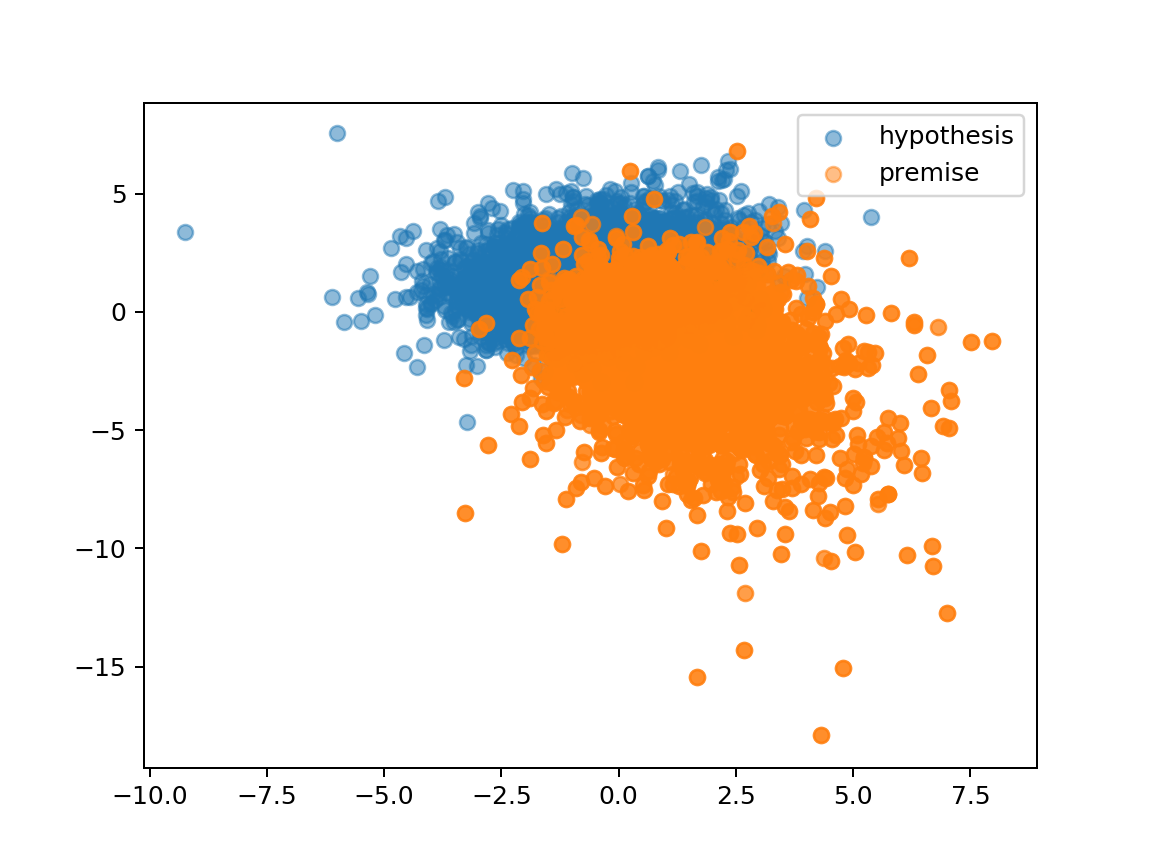

In [378]:
plt.scatter(h_hat[:, 0], h_hat[:, 1], alpha=0.5, label='hypothesis')
plt.scatter(p_hat[:, 0], p_hat[:, 1], alpha=0.5, label='premise')

plt.legend(loc='best')